In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm

import matplotlib.patches as mpatches

from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', None)

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']
path = "../data/"

In [3]:
# REMARK: There are no spherical TOKAMAKs in these analyses.  

DB2P8 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"DB5.csv")

DB2P8 = DB2P8[DB5.columns]

# How was this chosen? Is this a form of removing outliers or noise to the new regression?
# Why not simply use the whole DB5?
new_ids = pd.read_csv(path+"new_point_ids.csv")
                  
R = pd.read_csv(path+"R.csv") #DB5[DB5.id.isin(new_ids.id.values)] #reintroduce dataset

DB2 = DB2P8[["TAUTH"] + coeffs].apply(np.abs).apply(np.log)
DB2["id"] = DB2P8["id"]

reg_data = pd.read_csv(path+"data.csv")

In [4]:
def get_regression_np(_R):
    data = pd.concat([DB2, _R],
                     axis=0, 
                     ignore_index=True
                    )
    Y_ = data[["TAUTH"]].to_numpy()
    # Adding a column for the intercept
    _df = data[coeffs]; _df.insert(
        loc = 0, 
        column = "intercept", 
        value = np.ones(len(_df))
    )
    X_ = _df.to_numpy()
    n_, p_ = X_.shape
    model = sm.OLS(Y_,X_)
    regression = model.fit()
    return data, regression, (n_,p_)

# Getting regression of DB2P8 only. 
regression_DB2 = get_regression_np(R[R.id.isin([0])])[1]
#regression_DB2.summary()

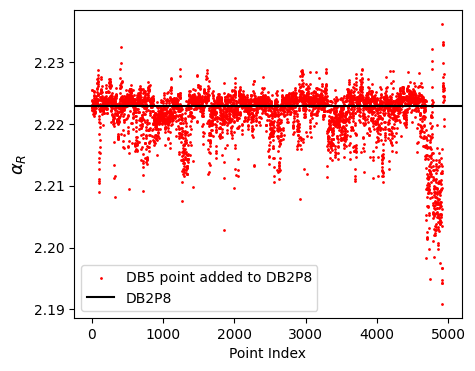

In [5]:
plt.figure(figsize=(5,4))
plt.scatter(reg_data.index, reg_data.αR, s=1, c="r", label="DB5 point added to DB2P8")
plt.axhline(regression_DB2.params[5], c="k", label="DB2P8")
plt.xlabel("Point Index")
plt.ylabel("$\\alpha_R$", fontsize=13)
plt.legend();

In [6]:
# Leave the ones above baseline out -- because we are interested in the reduction of value
pts_minimize = reg_data[reg_data.αR < regression_DB2.params[5] ]
pts_minimize = pts_minimize.sort_values("αR", ascending=True)


# Ordering dataset ids from smallest to greatest alpha-R 

dict_ordered_vals = dict(zip( 
    pts_minimize.id_added.values, 
    list(range(len(pts_minimize)))  
) )

DB5_decreas_pts = R[R.id.isin(pts_minimize.id_added)]
DB5_decreas_pts.insert(0, "ordered", DB5_decreas_pts.id.map(dict_ordered_vals))

DB5_decreas_pts = DB5_decreas_pts.sort_values("ordered")
DB5_decreas_pts = DB5_decreas_pts.set_index("ordered")

In [7]:
reg_coeff_per_pts = np.zeros(len(pts_minimize))
for i in range(1, len(pts_minimize) + 1):
    # Adding one point at a time to DB2P8 from DB5 od decreasing subset in an ordered manner.
    R_ = (DB5_decreas_pts.iloc[:i][["TAUTH"] + coeffs])
    # Storing regression coefficient for alpha_R only
    reg_coeff_per_pts[i-1] = get_regression_np(R_)[1].params[5]
    
DB5_decreas_pts["αR_per_pts_in_DB2"] = reg_coeff_per_pts

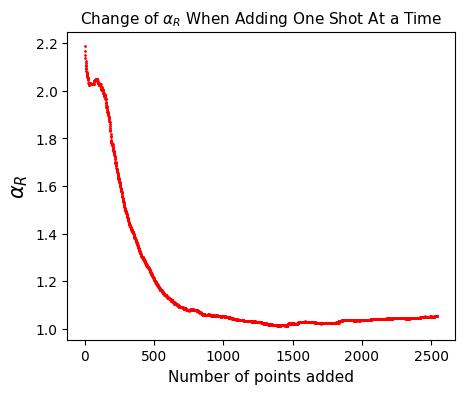

In [8]:
#%matplotlib notebook

plt.figure(figsize=(5,4))
plt.scatter(DB5_decreas_pts.index + 1, DB5_decreas_pts["αR_per_pts_in_DB2"], s=1, c = "r")
plt.xlabel("Number of points added", fontsize=11)
plt.ylabel("$\\alpha_R$", fontsize=15)
plt.title("Change of $\\alpha_R$ When Adding One Shot At a Time", fontsize=11);

In [9]:
# Labeling shots that decreased or increased the overall regression when added
df = DB5_decreas_pts[["αR_per_pts_in_DB2"]]
df.insert(0, "prev_val", [regression_DB2.params[5]] + list(df["αR_per_pts_in_DB2"].iloc[:-1].values))
df.insert(0, "difference", df["αR_per_pts_in_DB2"] - df["prev_val"])
DB5_decreas_pts.insert(0, "decreased", df.difference.apply(lambda x: 1 if x<=0 else 0))
DB5_decreas_pts.insert(0, "weights", DB5_decreas_pts.decreased.values/len(DB5_decreas_pts) + 1 )

In [10]:
num_samples = 500

"""max_amount = len( DB5_decreas_pts ) + 1
SAMPLES = np.zeros((num_samples, max_amount - 1))

for i in range(num_samples):
    for j in range(1, max_amount):
        R_sampled = DB5_decreas_pts.sample(n=j, weights='weights', random_state=71*(i + 3))
        SAMPLES[i,j-1] = get_regression_np(R_sampled)[1].params[5]""";

In [11]:
"""for s in range(num_samples):
    plt.plot(range(1, max_amount), SAMPLES[s,], label=f'seed {71*(s + 3)}')
plt.title("Sampling from Decreased Dataset")
plt.xlabel("Number of Random Samples in Decreasing DB5")
plt.ylabel("$\\alpha_R$", fontsize=15)
#plt.savefig("decreased_dataset_500.jpg", format="jpg", dpi=800);""";

In [12]:
"""for s in range(num_samples):
    print( min(SAMPLES[s,]), np.argmin(SAMPLES[s,]))""";

In [13]:
#big_dataset = pd.DataFrame(SAMPLES, columns=[f"subset_{i+1}" for i in range(SAMPLES.shape[-1])])
#big_dataset["seed"] = [71*(i + 3) for i in range(num_samples)]
#big_dataset.to_csv(path+"decreased_dataset_random_sampling_500.csv", index=False)

In [14]:
max_amount_ = len( DB5_decreas_pts[DB5_decreas_pts.decreased.isin([1])] ) + 1
SAMPLES_ = np.zeros((num_samples, max_amount_ - 1))

for i in range(num_samples):
    for j in range(600, max_amount_):
        R_sampled = DB5_decreas_pts.sample(n=j, weights='decreased', random_state=27*(i + 101))
        SAMPLES_[i,j-1] = get_regression_np(R_sampled)[1].params[5]

In [33]:
decreased_dataset = pd.DataFrame(SAMPLES_[:num_samples,599:], columns=[f"subset_{i+1}" for i in range(599,SAMPLES_.shape[-1])])
decreased_dataset["seed"] = [27*(i + 101) for i in range(num_samples)]
#decreased_dataset.to_csv(path+"decreased_dataset_random_sampling_500_decreasing_points_3.csv", index=False)
decreased_dataset

subset_600  subset_601  subset_602  subset_603  subset_604  subset_605  \
0      1.073845    1.065968    1.060537    1.060773    1.058566    1.051639   
1      1.063346    1.074962    1.072350    1.071814    1.073032    1.074555   
2      1.051678    1.051847    1.055052    1.053504    1.050116    1.051132   
3      1.074523    1.075093    1.074222    1.075558    1.072389    1.069701   
4      1.089242    1.083957    1.084554    1.086413    1.080207    1.068052   
..          ...         ...         ...         ...         ...         ...   
495    1.090474    1.089270    1.093380    1.091146    1.091884    1.090390   
496    1.086876    1.087302    1.081274    1.080799    1.077449    1.076798   
497    1.109494    1.112210    1.115196    1.113296    1.114403    1.100657   
498    1.088969    1.088425    1.084649    1.082656    1.086536    1.084145   
499    1.125665    1.124517    1.123168    1.123156    1.122190    1.131094   

     subset_606  subset_607  subset_608  subset_609  subset_610  subset_611  \
0      1.051799    1.052880    1.053299    1.054801    1.054770    1.057943   
1      1.080455    1.076286    1.070576    1.071925    1.067460    1.068836   
2      1.044547    1.043654    1.040614    1.037371    1.037217    1.036069   
3      1.072707    1.069703    1.067671    1.063996    1.064974    1.065581   
4      1.075447    1.068530    1.071804    1.072756    1.071539    1.071130   
..          ...         ...         ...         ...         ...         ...   
495    1.083346    1.084093    1.084725    1.083000    1.082653    1.083416   
496    1.079884    1.080021    1.086009    1.086898    1.075935    1.078468   
497    1.101374    1.100266    1.095923    1.095182    1.096157    1.093153   
498    1.093810    1.083420    1.076728    1.086988    1.091443    1.092357   
499    1.128095    1.135800    1.130543    1.133502    1.133624    1.130462   

     subset_612  subset_613  subset_614  subset_615  subset_616  subset_617  \
0      1.059238    1.058647    1.061435    1.068763    1.062250    1.060762   
1      1.070199    1.061089    1.069073    1.066973    1.066926    1.067057   
2      1.039299    1.039663    1.035491    1.038254    1.041615    1.042616   
3      1.067352    1.071362    1.088576    1.071862    1.067820    1.076336   
4      1.065553    1.065600    1.069010    1.068442    1.059612    1.061204   
..          ...         ...         ...         ...         ...         ...   
495    1.080812    1.080816    1.078824    1.073646    1.074478    1.069325   
496    1.075659    1.074463    1.072001    1.070761    1.075141    1.077173   
497    1.100236    1.099076    1.099871    1.097199    1.092670    1.094534   
498    1.084121    1.082840    1.071872    1.077960    1.074724    1.075761   
499    1.128618    1.111705    1.109124    1.122915    1.122742    1.109909   

     subset_618  subset_619  subset_620  subset_621  subset_622  subset_623  \
0      1.058731    1.067950    1.063635    1.059171    1.058423    1.056733   
1      1.062540    1.065413    1.058395    1.061553    1.062766    1.063612   
2      1.042446    1.044337    1.043145    1.039726    1.036380    1.037080   
3      1.073150    1.070175    1.069099    1.069668    1.066055    1.067611   
4      1.058020    1.063578    1.062074    1.060796    1.061731    1.061434   
..          ...         ...         ...         ...         ...         ...   
495    1.065096    1.064534    1.063661    1.066118    1.067813    1.062154   
496    1.076749    1.075190    1.069523    1.071689    1.069655    1.062354   
497    1.095709    1.091355    1.090838    1.091272    1.088538    1.087754   
498    1.073785    1.072550    1.071353    1.069266    1.071598    1.072737   
499    1.108316    1.108913    1.103559    1.106496    1.115979    1.116517   

     subset_624  subset_625  subset_626  subset_627  subset_628  subset_629  \
0      1.063473    1.059394    1.054557    1.059613    1.048470    1.049529   
1      1.057485    1.056606    1.053692    1.056343

(600.0, 1494.435)

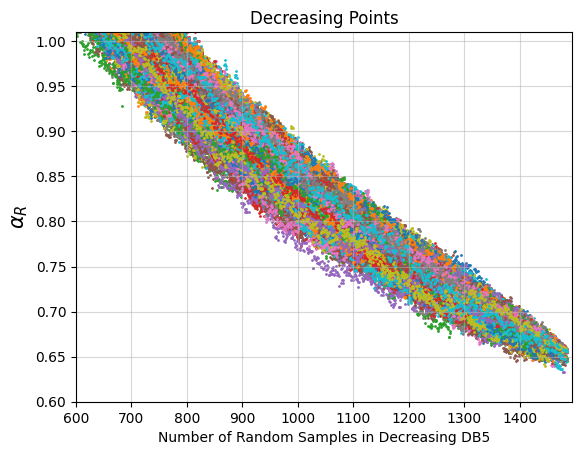

In [18]:
for s in range(num_samples):
    plt.scatter(range(1,max_amount_), SAMPLES_[s,], s=1)
plt.title("Decreasing Points")
plt.xlabel("Number of Random Samples in Decreasing DB5")
plt.ylabel("$\\alpha_R$", fontsize=15)

plt.grid(alpha=0.5)
ax = plt.gca()
ax.set_ylim([0.6, 1.01])
ax.set_xlim([600, max_amount_*1.005])

#plt.savefig("decreased_dataset_500_decreased_pts_zoom.jpg", format="jpg", dpi=800);

In [19]:
"""for s in range(num_samples):
    print( min(SAMPLES_[s,]), np.argmin(SAMPLES_[s,]))"""

'for s in range(num_samples):\n    print( min(SAMPLES_[s,]), np.argmin(SAMPLES_[s,]))'

In [20]:
decreased_dataset.describe()

,subset_600,subset_601,subset_602,subset_603,subset_604,subset_605,subset_606,subset_607,subset_608,subset_609,subset_610,subset_611,subset_612,subset_613,subset_614,subset_615,subset_616,subset_617,subset_618,subset_619,subset_620,subset_621,subset_622,subset_623,subset_624,subset_625,subset_626,subset_627,subset_628,subset_629,subset_630,subset_631,subset_632,subset_633,subset_634,subset_635,subset_636,subset_637,subset_638,subset_639,subset_640,subset_641,subset_642,subset_643,subset_644,subset_645,subset_646,subset_647,subset_648,subset_649,subset_650,subset_651,subset_652,subset_653,subset_654,subset_655,subset_656,subset_657,subset_658,subset_659,subset_660,subset_661,subset_662,subset_663,subset_664,subset_665,subset_666,subset_667,subset_668,subset_669,subset_670,subset_671,subset_672,subset_673,subset_674,subset_675,subset_676,subset_677,subset_678,subset_679,subset_680,subset_681,subset_682,subset_683,subset_684,subset_685,subset_686,subset_687,subset_688,subset_689,subset_690,subset_691,subset_692,subset_693,subset_694,subset_695,subset_696,subset_697,subset_698,subset_699,subset_700,subset_701,subset_702,subset_703,subset_704,subset_705,subset_706,subset_707,subset_708,subset_709,subset_710,subset_711,subset_712,subset_713,subset_714,subset_715,subset_716,subset_717,subset_718,subset_719,subset_720,subset_721,subset_722,subset_723,subset_724,subset_725,subset_726,subset_727,subset_728,subset_729,subset_730,subset_731,subset_732,subset_733,subset_734,subset_735,subset_736,subset_737,subset_738,subset_739,subset_740,subset_741,subset_742,subset_743,subset_744,subset_745,subset_746,subset_747,subset_748,subset_749,subset_750,subset_751,subset_752,subset_753,subset_754,subset_755,subset_756,subset_757,subset_758,subset_759,subset_760,subset_761,subset_762,subset_763,subset_764,subset_765,subset_766,subset_767,subset_768,subset_769,subset_770,subset_771,subset_772,subset_773,subset_774,subset_775,subset_776,subset_777,subset_778,subset_779,subset_780,subset_781,subset_782,subset_783,subset_784,subset_785,subset_786,subset_787,subset_788,subset_789,subset_790,subset_791,subset_792,subset_793,subset_794,subset_795,subset_796,subset_797,subset_798,subset_799,subset_800,subset_801,subset_802,subset_803,subset_804,subset_805,subset_806,subset_807,subset_808,subset_809,subset_810,subset_811,subset_812,subset_813,subset_814,subset_815,subset_816,subset_817,subset_818,subset_819,subset_820,subset_821,subset_822,subset_823,subset_824,subset_825,subset_826,subset_827,subset_828,subset_829,subset_830,subset_831,subset_832,subset_833,subset_834,subset_835,subset_836,subset_837,subset_838,subset_839,subset_840,subset_841,subset_842,subset_843,subset_844,subset_845,subset_846,subset_847,subset_848,subset_849,subset_850,subset_851,subset_852,subset_853,subset_854,subset_855,subset_856,subset_857,subset_858,subset_859,subset_860,subset_861,subset_862,subset_863,subset_864,subset_865,subset_866,subset_867,subset_868,subset_869,subset_870,subset_871,subset_872,subset_873,subset_874,subset_875,subset_876,subset_877,subset_878,subset_879,subset_880,subset_881,subset_882,subset_883,subset_884,subset_885,subset_886,subset_887,subset_888,subset_889,subset_890,subset_891,subset_892,subset_893,subset_894,subset_895,subset_896,subset_897,subset_898,subset_899,subset_900,subset_901,subset_902,subset_903,subset_904,subset_905,subset_906,subset_907,subset_908,subset_909,subset_910,subset_911,subset_912,subset_913,subset_914,subset_915,subset_916,subset_917,subset_918,subset_919,subset_920,subset_921,subset_922,subset_923,subset_924,subset_925,subset_926,subset_927,subset_928,subset_929,subset_930,subset_931,subset_932,subset_933,subset_934,subset_935,subset_936,subset_937,subset_938,subset_939,subset_940,subset_941,subset_942,subset_943,subset_944,subset_945,subset_946,subset_947,subset_948,subset_949,subset_950,subset_951,subset_952,subset_953,subset_954,subset_955,subset_956,subset_957,subset_958,subset_959,subset_960,subset_961,subset_962,subset

In [21]:
# Found Subset with Minimum alpha_R
decreased_dataset.describe().loc["min"].keys()[np.argmin(decreased_dataset.describe().loc["min"])]

'subset_1478'

In [22]:
# Minimum alpha_R generated by random sampling
min(decreased_dataset.describe().loc["min"]) 

0.6329368792497839

In [29]:
# Seed that generated the minimum alpha_R with 1466 sampling
indx = decreased_dataset[decreased_dataset["subset_1478"]
                         .isin([ min(decreased_dataset.describe().loc["min"])  ])].index
decreased_dataset["seed"][indx]

324    11475
Name: seed, dtype: int64

In [30]:
#random_sampling.to_csv(path+"random_sampling_min_subset.csv")

In [31]:
R_ = DB5_decreas_pts.sample(n=1459, weights='decreased', random_state=2535)
R_

,weights,decreased,ind,id,PHASE,TOK,IP,BT,NEL,PLTH,RGEO,KAREA,EPS,MEFF,TAUTH,DATE,SHOT,TIME,Q95,ZEFF,AMIN,VOL,POHM,PNBI,DWDIA,DWMHD,PICRH,PECRH,PL,PFLOSS,TAV,LCOULOMB,QCYL5,TAUBOHM,RHOSTAR,BETASTAR,NUSTAR,OMEGACYCL,αR_per_pts_in_DB2
ordered,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1314,1.000393,1,15090,YQUDX3,HGELM,AUG,0.000000,0.741937,1.504966,1.759581,0.493476,0.461215,-1.152029,0.693147,-2.345701,20030123,16740,2.050000,1.387544,NaN,0.517600,13.740000,161500.000000,4.700000e+06,NaN,-4252.00,1.558000e+06,0.0,6.420000e+06,334500.000000,2128.904327,15.992483,1.019510,0.100569,-4.750827,0.433690,-3.331275,1.050000,1.019276
2317,1.000393,1,20839,8M008Q,HGELM,JET,0.779783,1.103600,1.527794,2.608598,1.081127,0.453318,-1.179181,0.686123,-1.243754,19980120,44115,67.380000,1.393766,2.226000,0.906600,75.260000,225300.000000,1.413000e+07,381100.000000,NaN,0.000000e+00,0.0,1.397000e+07,388500.000000,2673.948125,16.209017,1.125188,0.437676,-5.562526,-0.038858,-3.016838,1.518127,1.043141
706,1.000393,1,21840,FZL55K,HSELM,JET,0.701539,1.165323,1.706607,2.777095,1.069389,0.420878,-1.139578,0.696385,-1.529196,20030327,59061,59.583801,1.656196,2.811129,0.932218,76.134399,383666.276932,1.296408e+07,-86668.014526,NaN,2.960367e+06,0.0,1.639478e+07,322523.426521,1965.534314,15.811819,1.310538,0.346366,-5.800879,-0.291283,-2.133043,1.598296,1.088245
200,1.000393,1,21606,68T7VW,HSELM,JET,0.430984,0.829998,1.498651,2.359016,1.053103,0.427222,-1.181277,1.349529,-2.076651,20010320,54149,65.876587,1.389239,2.839081,0.879700,67.127136,615527.153015,1.043160e+07,1901.609823,NaN,0.000000e+00,0.0,1.104523e+07,464693.094608,1045.084918,15.284131,1.139329,0.074558,-5.396830,-0.460256,-1.236557,0.594799,1.769719
881,1.000393,1,22768,B9LAHH,HGELMH,JETILW,0.680142,0.869867,1.607085,2.296780,1.068390,0.430073,-1.143020,0.570200,-1.371440,20160728,91252,56.000000,1.275715,1.000684,0.928087,76.081879,557401.416667,9.714511e+06,56165.900000,-11459.20,0.000000e+00,0.0,1.021575e+07,273634.352973,1573.680711,15.639233,1.029045,0.342401,-5.675249,-0.022241,-2.076176,1.349409,1.058977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,1.000393,1,14269,1DVA15,HGELM,AUG,0.001998,0.900974,1.589235,1.585145,0.500169,0.471877,-1.203165,0.693147,-1.964685,19980804,11197,3.650000,1.399457,2.496000,0.495100,12.790000,194500.000000,4.972000e+06,NaN,-84690.00,0.000000e+00,0.0,5.250000e+06,317300.000000,2246.505077,16.004116,1.085914,0.172586,-4.838537,0.253654,-3.204014,1.231000,1.035848
1118,1.000393,1,22904,0JNPQD,HGELMH,JETILW,0.317286,0.524482,1.249808,2.090307,1.064744,0.412556,-1.136958,0.561004,-1.788582,20160902,91755,46.500000,1.274768,1.111148,0.930332,74.849315,303957.890411,8.188789e+06,-21192.400000,1518.07,0.000000e+00,0.0,8.552082e+06,464686.033105,1225.577185,15.567866,1.036132,0.161201,-5.461880,0.061248,-1.943668,0.964137,1.036703
1062,1.000393,1,15461,KCFG2F,HGELM,AUGW,-0.000400,0.908662,2.154665,1.595339,0.473747,0.459322,-1.123451,0.693147,-2.464281,20080229,22755,2.750000,1.557723,1.265000,0.522200,13.680000,396600.000000,4.961000e+06,NaN,23980.00,0.000000e+00,0.0,5.330000e+06,381000.000000,842.112005,14.740184,1.220957,0.105529,-5.390124,-0.177509,-0.769367,1.240500,1.043189


In [32]:
get_regression_np(R_)[1].params[5]

0.6379155552428217

In [27]:
#R_[["id"]].to_csv(path+"R_ids_alpha_0.6379.csv", index=False)

In [28]:
dds_desc = decreased_dataset.describe().T
dds_desc[dds_desc["min"] < 1]

,count,mean,std,min,25%,50%,75%,max
subset_608,500.0,1.081780,2.436738e-02,0.998946,1.065172,1.081222,1.098223,1.150554
subset_609,500.0,1.081227,2.442940e-02,0.999502,1.064693,1.080993,1.097533,1.151348
subset_610,500.0,1.080524,2.427269e-02,0.996323,1.063062,1.080899,1.097079,1.152254
subset_612,500.0,1.079211,2.439509e-02,0.996385,1.062199,1.079585,1.095541,1.155407
subset_613,500.0,1.078496,2.418928e-02,0.994118,1.062397,1.077403,1.094977,1.155606
...,...,...,...,...,...,...,...,...
subset_1482,500.0,0.656986,1.804856e-03,0.644544,0.656390,0.657084,0.657834,0.661189
subset_1483,500.0,0.656703,1.374821e-03,0.644299,0.656190,0.656688,0.657360,0.660153
subset_1484,500.0,0.656358,1.199411e-03,0.644705,0.655968,0.656286,0.656856,0.658672
subset_1485,500.0,0.656061,1.072430e-03,0.644864,0.655848,0.656002,0.656318,0.658435
